In [ ]:
"""
What? CNN LSTMs

The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input 
data combined with LSTMs to support sequence prediction. CNN LSTMs were developed for visual time series prediction 
problems and the application of generating textual descriptions from sequences of images (e.g. videos).

https://machinelearningmastery.com/cnn-long-short-term-memory-networks/
"""

In [24]:
# Import python modules
from numpy import zeros, array
from random import randint
from random import random
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed

### Moving Square Video Prediction Problem

In [ ]:
"""
The problem involves the generation of a sequence of frames. In each image a line is drawn from left to right or 
right to left. Each frame shows the extension of the line by one pixel. The task is for the model to classify whether
the line moved left or right in the sequence of frames. Technically, the problem is a sequence classification problem
framed with a many-to-one prediction model.
"""

### Image Initialization

In [ ]:
"""
We can start off by defining a 2D NumPy array filled with zero values. We will make the images symmetrical, and in 
this case, 10 pixels by 10 pixels.
"""

In [2]:
frame = zeros((10,10))

In [ ]:
"""
Next, we can select the row for the first step of the line. We will use the randint() function to select a uniformly
random integer between 0 and 9.
"""

In [11]:
step = randint(0, 10-1)

In [ ]:
"""
We can now select whether we are drawing the line left or right across the image. We will use the random() function 
to decide. If right, we will start at the left, or column 0, and if left we will start on the right, or column 9.
"""

In [6]:
right = 1 if random() < 0.5 else 0
col = 0 if right else size-1

In [7]:
# We can now mark the start of the line.
frame[step, col] = 1

### Adding Steps

In [ ]:
"""
Now we need a process to add steps to the line. The next step must be a function of the previous step. We will 
constrain it to be in the next column along (left or right) and be in the same row, the row above or the row below.
We will further constrain the movement by the bounds of the image, e.g. no movements below row zero or above row 9.
"""

In [12]:
lower = max(0, last_step-1)
upper = min(10-1, last_step+1)
step = randint(lower, upper)

In [13]:
# Next, we can make a copy of the last image and mark the new position for the next column along.
column = i if right else size-1-i
frame = last_frame.copy()
frame[step, column] = 1

NameError: name 'i' is not defined

In [ ]:
"""
something has GONE wrong here, there is something missing in the code
"""

### Instance Generator

In [ ]:
"""
We can capture all of the above behavior in two small functions. The build frames() function takes an argument to 
define the size of the images and returns a sequence of images and whether the line moves right (1) or left (0). 
This function calls another function next frame() to create each subsequent frame after the first frame as the line
moves across the image. To make the problem concrete, we can plot one sequence. We will generate a small sequence 
with each image 5x5 pixels and with 5 frames and plot the frames side by side
"""

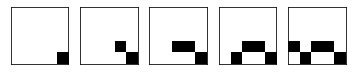

In [18]:
# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    # define the scope of the next step
    lower = max(0, last_step-1)
    upper = min(last_frame.shape[0]-1, last_step+1)
    # choose the row index for the next step
    step = randint(lower, upper)
    # copy the prior frame
    frame = last_frame.copy()
    # add the new step
    frame[step, column] = 1
    return frame, step

# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    frames = list()
    # create the first frame
    frame = zeros((size,size))
    step = randint(0, size-1)
    # decide if we are heading left or right
    right = 1 if random() < 0.5 else 0
    col = 0 if right else size-1
    frame[step, col] = 1
    frames.append(frame)
    # create all remaining frames
    for i in range(1, size):
        col = i if right else size-1-i
        frame, step = next_frame(step, frame, col)
        frames.append(frame)
    return frames, right

# generate sequence of frames
size = 5
frames, right = build_frames(size)
# plot all feames
pyplot.figure()
for i in range(size):
    # create a grayscale subplot for each frame
    pyplot.subplot(1, size, i+1)
    pyplot.imshow(frames[i], cmap= "Greys" )
    # turn of the scale to make it cleaer
    ax = pyplot.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# show the plot
pyplot.show()

### Prepare Input for Model

In [19]:
"""
Finally, we will prepare a function to generate multiple sequences with the correct shape ready for fitting and
evaluating an LSTM model.
"""

# generate multiple sequences of frames and reshape for network input
def generate_examples(size, n_patterns):
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    # resize as [samples, timesteps, width, height, channels]
    X = array(X).reshape(n_patterns, size, size, size, 1)
    y = array(y).reshape(n_patterns, 1)
    return X, y

### Define and Compile the Model

In [22]:
# configure problem
size = 50
# define the model
model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2,2), activation= "relu" ),
    input_shape=(None,size,size,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1, activation= "sigmoid" ))
model.compile(loss= "binary_crossentropy" , optimizer= "adam" , metrics=["acc"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 49, 49, 2)   10        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 24, 24, 2)   0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1152)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                240600    
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 240,661
Trainable params: 240,661
Non-trainable params: 0
_________________________________________________________________
None


### Fit the Model

In [ ]:
"""
Here we will train the model on a single epoch of 5,000 randomly generated sequences. Ideally, the internal state 
of the LSTM would be reset at the end of each sequence.
"""

In [26]:
# fit model
X, y = generate_examples(size, 5000)
model.fit(X, y, batch_size=32, epochs=1, verbose=1)

157/157 [==============================] - 41s 263ms/step - loss: 0.1958 - acc: 0.9274


### Evaluate the Model

In [ ]:
"""
Now that the model is fit, we can estimate the skill of the model on new random sequences. Here, we can generate 
100 new random sequences and evaluate the accuracy of the model. Running the example prints both the loss and 
accuracy of the fit model. Here, we can see the model achieves 100% accuracy. Your results may vary and if you 
do not see 100% accuracy, try running the example a few times.
"""

In [28]:
# evaluate model
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0)
print("loss: %f, acc: %f" % (loss, acc*100))

loss: 0.016118, acc: 100.000000


### Make Predictions With the Model

In [ ]:
"""
Here we generate a new single random sequence and predict whether the line is moving left or right
"""

In [30]:
# prediction on new data
X, y = generate_examples(size, 1)
yhat = model.predict_classes(X, verbose=0)
expected = "Right" if y[0]==1 else "Left"
predicted = "Right" if yhat[0]==1 else "Left"
print("Expected: %s, Predicted: %s"  % (expected, predicted))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Expected: Right, Predicted: Right
